In [72]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# File path for spectrogram .mat files.
file_path = r"data/spectrogram_CWRU_48k"

In [ ]:
# Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

# Function to downsample the y-axis (frequency axis) of a spectrogram
def downsample_spectrogram_y_axis(spectrogram, downsample_factor):
    return spectrogram[::downsample_factor, :]

def load_data(file_numbers, file_path, labels_mapping, slice_width, std_num, downsample_factor):
    data = []
    labels = []
    # Loop through each file number to process its corresponding file.
    for file_number in file_numbers:
        label = labels_mapping[file_number]  # Retrieve the label for the current file.
        file_name = f"spectrogram_{file_number}.mat"  # Construct the file name.
        full_path = os.path.join(file_path, file_name)  # Construct the full file path.
        mat_contents = scipy.io.loadmat(full_path)  # Load the .mat file.

        # Extract the spectrogram data from the loaded .mat content.
        sxx = mat_contents['spectrogram']
       
        # If the spectrogram's frequency axis is less than 250, pad it to reach 250.
        if sxx.shape[0] < 250:
            pad_size = 250 - sxx.shape[0]
            sxx = np.pad(sxx, ((0, pad_size), (0, 0)), 'constant', constant_values=(0, 0))
            
        # Downsample the spectrogram by the specified factor along the y-axis.
        ds = downsample_spectrogram_y_axis(sxx, downsample_factor)
        
        # Calculate the number of slices that can be made across the width of the spectrogram.
        num_slices = sxx.shape[1] // slice_width
        
        # Slice the downsampled spectrogram into smaller segments of specified width.
        for i in range(num_slices):
            start_index = i * slice_width
            end_index = start_index + slice_width
            spectrogram_slice = ds[:, start_index:end_index]
            
            # Standardize each slice by subtracting its mean and dividing by its standard deviation.
            avg_y = np.mean(spectrogram_slice)
            std_y = np.std(spectrogram_slice)
            standardized_sxx = (spectrogram_slice - avg_y) / std_y
            
            # Clip the standardized values to reduce the effect of extreme outliers.
            clean_y = np.clip(standardized_sxx, -std_num, std_num)
            clean_y_min = np.min(clean_y)
            clean_y_max = np.max(clean_y)
            epsilon = 1e-10
            
            # Normalize the clipped data to have a minimum of 0 and a maximum of 1.
            norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min + epsilon)
            
            # Transpose the normalized slice to match the expected input shape for neural networks.
            spectrogram_slice = np.transpose(norm_y, (1, 0))
            data.append(spectrogram_slice)  # Add the processed slice to the data list.
            labels.append(label)  # Add the corresponding label to the labels list.

    # Convert the lists of data and labels into numpy arrays and return.
    return np.array(data), np.array(labels)



# Training files included for training 
included_numbers = [112,177,110,111,175,176,214,215,
                   125,192,123,124,190,191,227,228,
                   204,241,136,137,202,203,239,240]

# Benchmark files 
unseen_numbers = [229,217,138] 


# Define mappings for each bearing fault label
inner_race_files = [110,111,112,175,176,177,214,215]
ball_files = [123,124,125,190,191,192,227,228]
outer_files = [136,137,202,203,204,239,240,241]

# Unseen benchmark labels 
A = [217]
B = [229]
C = [138]


unseen_file_numbers_to_labels = {}
for file_number in A:
    unseen_file_numbers_to_labels[file_number] = 'inner'
for file_number in B:
    unseen_file_numbers_to_labels[file_number] = 'ball'
for file_number in C:
    unseen_file_numbers_to_labels[file_number] = 'outer'


file_numbers_to_labels = {}
for file_number in inner_race_files:
    file_numbers_to_labels[file_number] = 'inner'
for file_number in ball_files:
    file_numbers_to_labels[file_number] = 'ball'
for file_number in outer_files:
    file_numbers_to_labels[file_number] = 'outer'







# Slice width of input 
slice_width = 3

# Number of classes for classification
n_classes = 3

# Standdard deviation number used to normalize
std_num = 3

# Downsample factor for the frequncy axis 
downsample_factor = 1

# Activation fucntion used for training the transformer
act_func = "gelu"


# Load data and labels 
data, labels = load_data(included_numbers, file_path, file_numbers_to_labels, slice_width, std_num, downsample_factor)


# Initialize a label encoder for converting string labels to numeric labels
label_encoder = LabelEncoder()

# Fit the label encoder to the labels and transform them into numeric labels
numeric_labels = label_encoder.fit_transform(labels)

# Load unseen data and labels using the specified function and parameters
unseen_data, unseen_labels = load_data(unseen_numbers, file_path, unseen_file_numbers_to_labels, slice_width, std_num, downsample_factor)

# Initialize another label encoder for the unseen data labels
label_encoder2 = LabelEncoder()

# Fit the label encoder to the unseen labels and transform them into numeric labels
numeric_labels2 = label_encoder2.fit_transform(unseen_labels)

# Transform the unseen labels again to ensure consistency in label encoding
unseen_numeric_labels = label_encoder2.transform(unseen_labels)

# Convert the numeric labels into one-hot encoded format for use in neural network models
unseen_one_hot_labels = to_categorical(unseen_numeric_labels)

# Split the loaded data into training, validation, and temporary sets using an 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(data, numeric_labels, test_size=0.2, random_state=42)

# Further split the temporary set equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the training, validation, and test labels to one-hot encodings
y_train_one_hot = to_categorical(y_train)  # for the training set
y_val_one_hot = to_categorical(y_val)      # for the validation set
y_test_one_hot = to_categorical(y_test)    # for the test set



#Transformer block
def transformer_block(x, num_heads, ff_dim, rate):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attention_output = layers.Dropout(rate)(attention_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward part of the transformer
    ff_output = layers.Dense(ff_dim, activation=act_func)(out1)
    ff_output = layers.Dense(x.shape[-1])(ff_output)
    ff_output = layers.Dropout(rate)(ff_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ff_output)

    return out2
    


# Build Transformer model
def build_transformer(sequence_length, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout_rate, embedding_dim, n_classes):
    # Input layer specifying shape according to provided sequence length and embedding dimension
    inputs = keras.Input(shape=(sequence_length, embedding_dim))
    
    # Dense layer to project inputs to a higher-dimensional space defined by ff_dim
    x = layers.Dense(ff_dim, activation=act_func)(inputs)
    
    # Add positional encoding to the input features
    x = PositionalEncoding(sequence_length, ff_dim)(x)
    
    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads, ff_dim, dropout_rate)
        
    # Global average pooling to reduce the feature dimensions
    x = layers.GlobalAveragePooling1D()(x)
    
    # Sequentially add dense layers with dropout for regularization as specified in mlp_units
    for units in mlp_units:
        x = layers.Dense(units, activation=act_func)(x)
        x = layers.Dropout(dropout_rate)(x)
        
    # Final dense layer for classification with softmax activation to output probabilities
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    # Construct and return the Keras model instance
    model = models.Model(inputs, outputs)
    return model

# PositionalEncoding class to add positional information to the inputs
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(sequence_length, embedding_dim)
    
    def get_angles(self, position, i, embedding_dim):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embedding_dim))
        return position * angles

    def positional_encoding(self, sequence_length, embedding_dim):
        angle_rads = self.get_angles(np.arange(sequence_length)[:, np.newaxis],
                                     np.arange(embedding_dim)[np.newaxis, :],
                                     embedding_dim)
        
        # Apply sin to even indices; 2i
        sines = np.sin(angle_rads[:, 0::2])
        
        # Apply cos to odd indices; 2i+1
        cosines = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
        
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



sequence_length = slice_width  # Set the sequence length for the transformer model to the defined slice width
num_heads = 6  # Number of attention heads in the multi-head attention mechanism
ff_dim = 128  # Dimension of the feed-forward network in each transformer block
num_transformer_blocks = 3  # Number of transformer blocks in the model
mlp_units = [64,32]  # List specifying the size of each dense layer in the final part of the model
dropout_rate = 0.25  # Dropout rate used in dropout layers for regularization

# Calculate the embedding dimension based on a factor of the original dimension size
embedding_dim = 250 // downsample_factor

# Configure a callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,  # Factor by which to reduce the learning rate
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,  # Lower bound on the learning rate
    verbose=1  # Print messages when the callback takes action
)

# Build and compile the transformer model
model = build_transformer(
    sequence_length, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout_rate, embedding_dim, n_classes
)
model.compile(
    optimizer=Adam(0.0001),  # Use the Adam optimizer with a learning rate of 0.0001
    loss='categorical_crossentropy',  # Use categorical crossentropy loss
    metrics=["accuracy"]  # Tracks accuracy during training
)

# Train the model 
history = model.fit(
    X_train, y_train_one_hot,  # Training data and labels
    callbacks=[reduce_lr],  # Include the reduce learning rate callback
    batch_size=32,  # Number of samples per gradient update
    epochs=70,  # Number of epochs to train the model
    validation_data=(X_val, y_val_one_hot),  # Data on which to evaluate the loss and any model metrics at the end of each epoch
    verbose=1  # Turn on verbose output for training output
)


#Prediction on unseen data
unseen_pred = model.predict(unseen_data)
unseen_pred_classes = np.argmax(unseen_pred, axis=1)
unseen_true = np.argmax(unseen_one_hot_labels, axis=1)

# Evaluation Metrics
unseen_accuracy = accuracy_score(unseen_true, unseen_pred_classes)
unseen_f1 = f1_score(unseen_true, unseen_pred_classes, average='weighted')
unseen_precision = precision_score(unseen_true, unseen_pred_classes, average='weighted', zero_division=0)

# Print Evaluation Metrics for Unseen Data
print(f'Accuracy on unseen data: {unseen_accuracy}')
print(f'F1 Score on unseen data: {unseen_f1}')
print(f'Precision on unseen data: {unseen_precision}')

# Confusion Matrix for Unseen Data
unseen_cm = confusion_matrix(unseen_true, unseen_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(unseen_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Unseen Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Prediction on training data
train_pred = model.predict(X_train)
train_pred_classes = np.argmax(train_pred, axis=1)
train_true_classes = np.argmax(y_train_one_hot, axis=1)

# Collect Training Metrics
train_accuracy = accuracy_score(train_true_classes, train_pred_classes)
train_f1 = f1_score(train_true_classes, train_pred_classes, average='weighted')
train_precision = precision_score(train_true_classes, train_pred_classes, average='weighted', zero_division=0)

# Print Evaluation Metrics for Training Data
print(f'Accuracy on seen data: {train_accuracy}')
print(f'F1 Score on seen data: {train_f1}')
print(f'Precision on seen data: {train_precision}')



KeyboardInterrupt: 

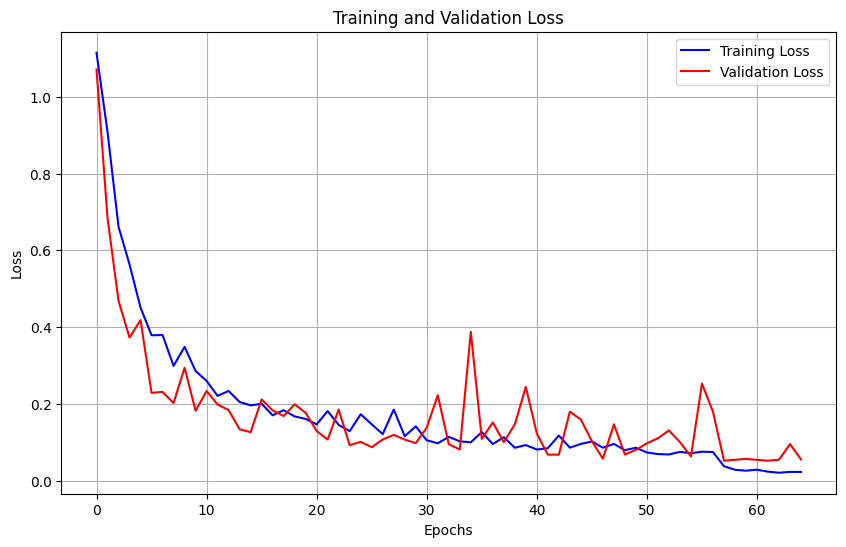

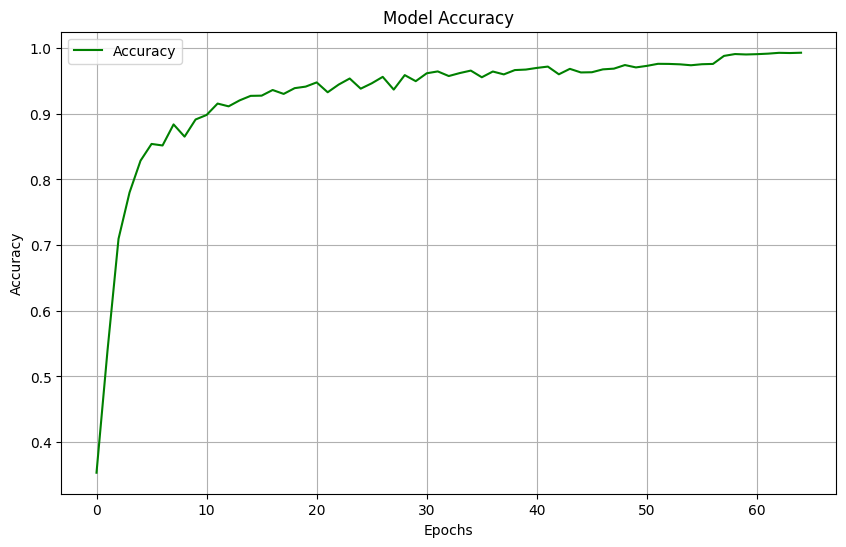

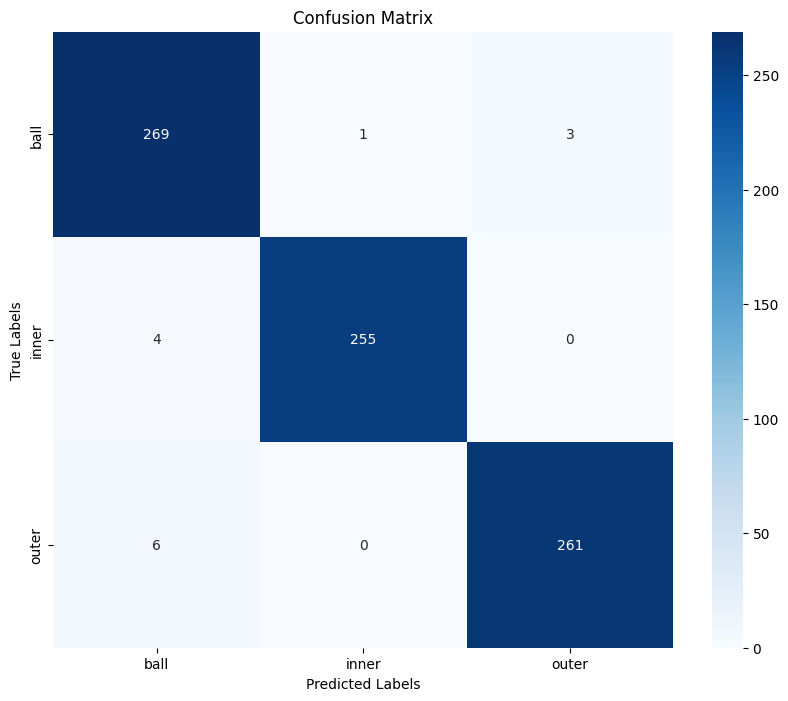

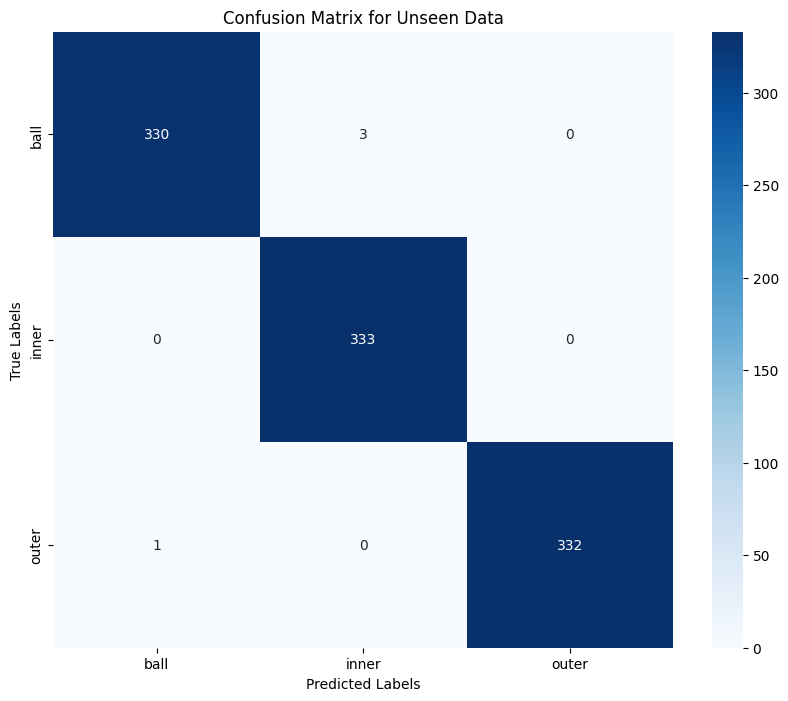

In [55]:



plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['loss'], label='Training Loss', color='blue')
sns.lineplot(data=history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
#plt.savefig("CWRU_traning_loss_9959.pdf")
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['accuracy'], label='Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
#plt.savefig("CWRU_model_accuracy_9959.pdf")
plt.show()



# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#plt.savefig("CWRU_CF_seen:9959.pdf")
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(unseen_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Unseen Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#plt.savefig("CWRU_CF_unseen_9959.pdf")
plt.show()